# Brain Tumor Classification Using CNN 🧠

In [1]:
import os
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 

# Data Preprocessing 

In [2]:
# one hot encoding the target 

In [3]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]])

# 0- no tumor(Normal) 

# 1- Tumor

OneHotEncoder()

In [4]:
# image preprocessing for tumor images

data = []
paths = []
result = []
# change the directory to your own
for r, d, f in os.walk("/Users/mesaye/Documents/GitHub/Deep-Learning/yes"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [5]:
# image preprocessing for no tumor images

paths = []

for r, d, f in os.walk("/Users/mesaye/Documents/GitHub/Deep-Learning/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [6]:
data = np.array(data)
data.shape

(1010, 128, 128, 3)

In [7]:
result = np.array(result)
result = result.reshape(1010,2)

In [8]:
#data

In [9]:
# split into train and test set
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

In [10]:
# data normalization

x_valid, x_train = x_train[:250] / 255 , x_train[250:] / 255
y_valid, y_train = y_train[:250], y_train[250:]
x_test = x_test / 255.

In [11]:
print(x_valid.shape)
print(y_valid.shape)
print(y_train.shape)
print(x_test.shape)
print(x_train.shape)

(250, 128, 128, 3)
(250, 2)
(558, 2)
(202, 128, 128, 3)
(558, 128, 128, 3)


# Build the CNN Neural Network

In [12]:


#model = Sequential()

#model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
#model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
#model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#model.add(Flatten())

#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(2, activation='softmax'))



In [13]:
#testing different (deeper) architecture. 

model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

2022-04-28 10:07:03.436892: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.compile(loss = "categorical_crossentropy", optimizer='Adam',metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4128      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

In [15]:
# fit the model

history = model.fit(x_train, y_train, epochs = 10, verbose = 1,validation_data = (x_valid, y_valid))



Epoch 1/10
18/18 [==============================] - 9s 439ms/step - loss: 0.6343 - accuracy: 0.6631 - val_loss: 0.5445 - val_accuracy: 0.8560
Epoch 2/10
18/18 [==============================] - 8s 454ms/step - loss: 0.5259 - accuracy: 0.8226 - val_loss: 0.5156 - val_accuracy: 0.8440
Epoch 3/10
18/18 [==============================] - 8s 420ms/step - loss: 0.4642 - accuracy: 0.8226 - val_loss: 0.4433 - val_accuracy: 0.8640
Epoch 4/10
18/18 [==============================] - 7s 412ms/step - loss: 0.3581 - accuracy: 0.8746 - val_loss: 0.3098 - val_accuracy: 0.8920
Epoch 5/10
18/18 [==============================] - 8s 418ms/step - loss: 0.2778 - accuracy: 0.8853 - val_loss: 0.2698 - val_accuracy: 0.8920
Epoch 6/10
18/18 [==============================] - 7s 411ms/step - loss: 0.2462 - accuracy: 0.9104 - val_loss: 0.2591 - val_accuracy: 0.8960
Epoch 7/10
18/18 [==============================] - 7s 403ms/step - loss: 0.2538 - accuracy: 0.9032 - val_loss: 0.2301 - val_accuracy: 0.9200
Epoch 

In [16]:
score = model.evaluate(x_test, y_test)


7/7 [==============================] - 1s 81ms/step - loss: 0.2096 - accuracy: 0.9208


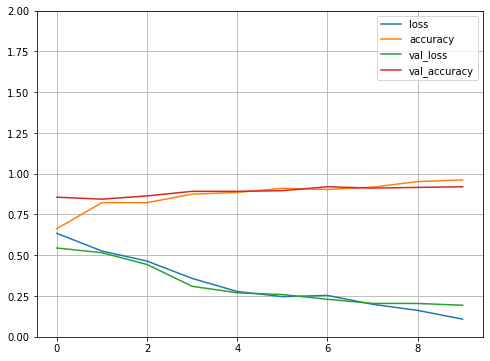

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

# Prediction 

In [18]:
def names(number):
    if number==0:
        return 'No Tumor detected'
    else:
        return 'Tumor detected'

In [19]:
from matplotlib.pyplot import imshow
img = Image.open("/Users/mesaye/Desktop/brain images/never seen image/Cancer (1).jpg")# never seen image 

x = np.array(img.resize((128,128)))

x = x.reshape(1,128,128,3)




100.0% Confidence No Tumor detected


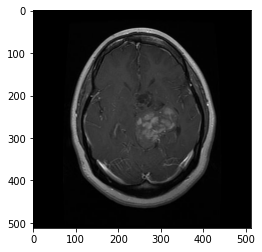

In [20]:
res = model.predict(x)

classification = np.where(res == np.amax(res))[1][0]

imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))

In [21]:
from matplotlib.pyplot import imshow
img = Image.open("/Users/mesaye/Desktop/brain images/never seen image/Not Cancer  (4).jpg")# never seen image 

x = np.array(img.resize((128,128)))

x = x.reshape(1,128,128,3)




100.0% Confidence No Tumor detected


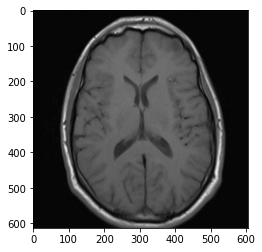

In [22]:
res = model.predict(x)

classification = np.where(res == np.amax(res))[1][0]

imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))